# Lecture 5 Part 2: Advanced Financial Analysis - Tesla (TSLA)

**Continued from Part 1**
In this part, we cover Liquidity, Efficiency, Returns, and EVA.


In [1]:
# Optional: Download / refresh Tesla data files (run only if needed)
# This cell is intentionally commented out to prevent accidental API calls during class.
#
# from pathlib import Path
# import yfinance as yf
#
# DATA_DIR = Path("data")
# DATA_DIR.mkdir(parents=True, exist_ok=True)
#
# t = yf.Ticker("TSLA")
#
# Annual statements
# (t.financials.transpose()).to_excel(DATA_DIR / "tesla_income_stmt.xlsx")
# (t.balance_sheet.transpose()).to_excel(DATA_DIR / "tesla_balance_sheet.xlsx")
# (t.cashflow.transpose()).to_excel(DATA_DIR / "tesla_cash_flow.xlsx")
#
# Quarterly statements (used for trend visualization)
# (t.quarterly_financials.transpose()).to_excel(DATA_DIR / "tesla_quarterly_financials.xlsx")
# (t.quarterly_balance_sheet.transpose()).to_excel(DATA_DIR / "tesla_quarterly_balance.xlsx")
# (t.quarterly_cashflow.transpose()).to_excel(DATA_DIR / "tesla_quarterly_cashflow.xlsx")


In [2]:
# Load local financial statements (no network calls)

import pandas as pd
from pathlib import Path

DATA_DIR = Path('data')

income_stmt = pd.read_excel(DATA_DIR / 'tesla_income_stmt.xlsx', index_col=0)
balance_sheet = pd.read_excel(DATA_DIR / 'tesla_balance_sheet.xlsx', index_col=0)
cash_flow = pd.read_excel(DATA_DIR / 'tesla_cash_flow.xlsx', index_col=0)

for df in (income_stmt, balance_sheet, cash_flow):
    df.index = pd.to_datetime(df.index, errors='coerce')
    df.sort_index(ascending=False, inplace=True)

FILTER_START_DATE = '2022-01-01'
income_stmt = income_stmt[income_stmt.index >= FILTER_START_DATE]
balance_sheet = balance_sheet[balance_sheet.index >= FILTER_START_DATE]
cash_flow = cash_flow[cash_flow.index >= FILTER_START_DATE]


In [3]:
# Trend visualization helper (executed in Step 12)

from pathlib import Path
import pandas as pd


def plot_trend_return_metrics(data_dir: Path = Path('data'), start: str = '2024-01-01', end: str = '2025-12-31'):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    q_fin = pd.read_excel(data_dir / 'tesla_quarterly_financials.xlsx', index_col=0)
    q_bs = pd.read_excel(data_dir / 'tesla_quarterly_balance.xlsx', index_col=0)

    q_fin.index = pd.to_datetime(q_fin.index, errors='coerce')
    q_bs.index = pd.to_datetime(q_bs.index, errors='coerce')
    q_fin = q_fin.sort_index()
    q_bs = q_bs.sort_index()

    tax_rate = (q_fin['Tax Provision'] / q_fin['Pretax Income']).replace([float('inf'), float('-inf')], pd.NA)
    tax_rate = tax_rate.clip(lower=0, upper=0.35).fillna(0.21)

    ebit = q_fin['EBIT']
    net_income = q_fin['Net Income']

    assets = q_bs['Total Assets']
    equity = q_bs['Stockholders Equity']
    debt = q_bs['Total Debt']
    current_liab = q_bs['Current Liabilities']

    nopat = ebit * (1 - tax_rate)
    invested_capital = debt + equity
    capital_employed = assets - current_liab

    ratios_q = pd.DataFrame(
        {
            'ROA': net_income / assets,
            'ROE': net_income / equity,
            'ROIC': nopat / invested_capital,
            'ROCE': ebit / capital_employed,
        }
    ).replace([float('inf'), float('-inf')], pd.NA)

    ratios_m = ratios_q.resample('M').interpolate('linear').loc[start:end]

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    fig.suptitle('Tesla Return Metrics (Monthly Interpolated: 2024-2025)', fontsize=16, fontweight='bold')

    for ax, metric in zip(axes.flat, ['ROA', 'ROE', 'ROIC', 'ROCE']):
        ax.plot(ratios_m.index, ratios_m[metric], linewidth=2)
        ax.set_title(metric, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Step 3: Profitability Analysis

Profitability analysis answers the question: "**How capable is this company of generating profit relative to its revenue or costs?**"

We will calculate three core metrics:

### 1. Gross Margin
Reflects the profitability of the product itself.

$$ \text{Gross Margin} = \frac{\text{Gross Profit}}{\text{Total Revenue}} $$

### 2. Operating Profit Margin
Reflects the operating efficiency of the company's core business (before interest and taxes).

$$ \text{Operating Margin} = \frac{\text{Operating Income}}{\text{Total Revenue}} $$

### 3. Net Profit Margin
Reflects the final profit remaining for shareholders after deducting all expenses.

$$ \text{Net Profit Margin} = \frac{\text{Net Income}}{\text{Total Revenue}} $$

In [4]:
# Step 3: Profitability (margins)

revenue = income_stmt['Total Revenue']

profitability_df = pd.DataFrame(
    {
        'Gross Margin': income_stmt['Gross Profit'] / revenue,
        'Operating Margin': income_stmt['Operating Income'] / revenue,
        'Net Margin': income_stmt['Net Income'] / revenue,
    }
)

profitability_df


,Gross Margin,Operating Margin,Net Margin
2025-12-31,0.180265,0.051135,0.040010
2024-12-31,0.178626,0.079435,0.072986
2023-12-31,0.182489,0.091875,0.154992
2022-12-31,0.255984,0.169797,0.154465


## Step 4: Liquidity Analysis

Liquidity analysis measures a company's ability to **pay off short-term debts**. This is crucial for assessing short-term survival risk.

### 1. Current Ratio
The most widely used metric, measuring if current assets cover current liabilities.

$$ \text{Current Ratio} = \frac{\text{Current Assets}}{\text{Current Liabilities}} $$

### 2. Quick Ratio
A stricter test. It excludes inventory, which is slower to convert to cash.

$$ \text{Quick Ratio} = \frac{\text{Current Assets} - \text{Inventory}}{\text{Current Liabilities}} $$

### 3. Cash Ratio
The strictest test. Looks only at cash on hand.

$$ \text{Cash Ratio} = \frac{\text{CashAndCashEquivalents}}{\text{Current Liabilities}} $$

In [5]:
# Step 4: Liquidity

liquidity_df = pd.DataFrame(
    {
        'Current Ratio': balance_sheet['Current Assets'] / balance_sheet['Current Liabilities'],
        'Quick Ratio': (balance_sheet['Current Assets'] - balance_sheet['Inventory']) / balance_sheet['Current Liabilities'],
        'Cash Ratio': balance_sheet['Cash And Cash Equivalents'] / balance_sheet['Current Liabilities'],
    }
)

liquidity_df.round(2)


,Current Ratio,Quick Ratio,Cash Ratio
2025-12-31,2.16,1.77,0.52
2024-12-31,2.02,1.61,0.56
2023-12-31,1.73,1.25,0.57
2022-12-31,1.53,1.05,0.61


## Step 5: Efficiency Analysis

Efficiency metrics measure how fast and efficiently a company manages its assets (like inventory, receivables, and payables).

### 1. Inventory Turnover
Measures how fast inventory is sold. **Note**: For precision, the denominator usually uses the average of beginning and ending inventory. For simplicity in teaching, we use the year-end value here.

$$ \text{Inventory Turnover} = \frac{\text{Cost of Revenue}}{\text{Inventory}} $$

### 2. Receivables Turnover & Days Sales Outstanding (DSO)
Measures how fast the company collects cash from its credit customers.
- **Receivables Turnover**: Times per year receivables are collected.
- **DSO**: Average number of days to collect payment.

$$ \text{Receivables Turnover} = \frac{\text{Total Revenue}}{\text{Accounts Receivable}} $$
$$ \text{DSO} = \frac{365}{\text{Receivables Turnover}} $$

### 3. Payables Turnover & Days Payable Outstanding (DPO)
Measures how slowly the company pays its suppliers.
- **Payables Turnover**: Times per year the company pays its creditors.
- **DPO**: Average number of days to pay suppliers.

$$ \text{Payables Turnover} = \frac{\text{Cost of Revenue}}{\text{Accounts Payable}} $$
$$ \text{DPO} = \frac{365}{\text{Payables Turnover}} $$

### 4. Asset Turnover
Measures how much revenue is generated per unit of asset.

$$ \text{Asset Turnover} = \frac{\text{Total Revenue}}{\text{Total Assets}} $$

In [6]:
# Step 5: Efficiency

revenue = income_stmt['Total Revenue']
cost_of_revenue = income_stmt['Cost Of Revenue']

inventory = balance_sheet['Inventory']
receivables = balance_sheet['Accounts Receivable']
payables = balance_sheet['Accounts Payable']
assets = balance_sheet['Total Assets']

inventory_turnover = cost_of_revenue / inventory
receivables_turnover = revenue / receivables
payables_turnover = cost_of_revenue / payables
asset_turnover = revenue / assets

# Days outstanding
DSO = 365 / receivables_turnover
DPO = 365 / payables_turnover

pd.DataFrame(
    {
        'Inventory Turnover (x)': inventory_turnover,
        'Receivables Turnover (x)': receivables_turnover,
        'DSO (Days)': DSO,
        'Payables Turnover (x)': payables_turnover,
        'DPO (Days)': DPO,
        'Asset Turnover (x)': asset_turnover,
    }
).round(2)


,Inventory Turnover (x),Receivables Turnover (x),DSO (Days),Payables Turnover (x),DPO (Days),Asset Turnover (x)
2025-12-31,6.27,20.72,17.61,5.81,62.78,0.69
2024-12-31,6.68,22.11,16.51,6.43,56.74,0.80
2023-12-31,5.81,27.59,13.23,5.48,66.58,0.91
2022-12-31,4.72,27.60,13.23,3.97,91.87,0.99


## Step 6: Return Analysis

This is what investors care about most—the return on invested capital.


### 1. Return on Assets (ROA)
**Meaning**: *This metric assesses how effectively management is utilizing the company's entire asset base to generate earnings, serving as a fundamental test of operational capability.*

Measures management's ability to generate profit using all assets.

$$ \text{ROA} = \frac{\text{Net Income}}{\text{Total Assets}} $$

<div style='text-align:center'><img src='pic/ROA.png' alt='ROA' width='600'/></div>

### 2. Return on Equity (ROE)
**Meaning**: *This figure reveals the direct return earned on the capital provided by shareholders, indicating how efficiently their equity is being compounded.*

Measures the return efficiency on shareholders' invested capital.

$$ \text{ROE} = \frac{\text{Net Income}}{\text{Stockholders Equity}} $$

<div style='text-align:center'><img src='pic/ROE.png' alt='ROE' width='600'/></div>

In [7]:
# Step 6: Returns (ROA, ROE)

total_assets = balance_sheet['Total Assets']
equity = balance_sheet['Stockholders Equity']

return_df = pd.DataFrame(
    {
        'ROA': income_stmt['Net Income'] / total_assets,
        'ROE': income_stmt['Net Income'] / equity,
    }
)

return_df


,ROA,ROE
2025-12-31,0.027531,0.046191
2024-12-31,0.058409,0.097788
2023-12-31,0.140680,0.239471
2022-12-31,0.152821,0.281474



## Step 7: DuPont Analysis
**"The Microscope of Financial Performance"**

DuPont Analysis breaks down Return on Equity (ROE) into three distinct drivers, helping us identify specific areas of strength or weakness.

$$ \text{ROE} = \text{Net Profit Margin} \times \text{Asset Turnover} \times \text{Equity Multiplier} $$

Where:
1.  **Net Profit Margin** ($\frac{\text{Net Income}}{\text{Revenue}}$): Measures **Profitability** (efficiency in cost control).
2.  **Asset Turnover** ($\frac{\text{Revenue}}{\text{Total Assets}}$): Measures **Operating Efficiency** (efficiency in using assets to generate sales).
3.  **Equity Multiplier** ($\frac{\text{Total Assets}}{\text{Equity}}$): Measures **Financial Leverage** (risk-taking/debt usage).


In [8]:
# Step 7: DuPont decomposition (ROE)

revenue = income_stmt['Total Revenue']
net_income = income_stmt['Net Income']
assets = balance_sheet['Total Assets']
equity = balance_sheet['Stockholders Equity']

dupont_df = pd.DataFrame(
    {
        'Net Margin': net_income / revenue,
        'Asset Turnover': revenue / assets,
        'Equity Multiplier': assets / equity,
    }
)

dupont_df


,Net Margin,Asset Turnover,Equity Multiplier
2025-12-31,0.040010,0.688120,1.677758
2024-12-31,0.072986,0.800279,1.674187
2023-12-31,0.154992,0.907661,1.702238
2022-12-31,0.154465,0.989361,1.841849


## Step 8: Return on Invested Capital (ROIC) & ROCE
**"The Core Operating Performance"**

ROA and ROE can be influenced by capital structure (debt levels). To measure the pure success of the core business logic, we use ROIC and ROCE.


### 1. ROIC (Return on Invested Capital)
**Meaning**: *By measuring the return on all capital invested (debt + equity), this ratio isolates core operating performance from financing decisions, offering a purer view of business quality.*

Measures the return generated by all capital providers (debt + equity).
$$ \text{ROIC} = \frac{\text{NOPAT}}{\text{Invested Capital}} $$
*   **NOPAT** (Net Operating Profit After Tax): $EBIT \times (1 - \text{Tax Rate})$
*   **Invested Capital**: Total Debt + Total Equity


<div style='text-align:center'><img src='pic/ROIC.png' alt='ROIC' width='600'/></div>

### 2. ROCE (Return on Capital Employed)
**Meaning**: *This ratio provides a long-term perspective on profitability by comparing operating profit to the capital permanently employed in the business.*

Useful for comparing capital-intensive industries across different tax regimes.
$$ \text{ROCE} = \frac{\text{EBIT}}{\text{Capital Employed}} $$
*   **Capital Employed**: Total Assets - Current Liabilities (approximated as Long-term Capital)


<div style='text-align:center'><img src='pic/ROCE.png' alt='ROCE' width='600'/></div>

In [9]:
# Step 8: ROIC and ROCE

# Tax rate (fallback to 21% if components are missing)
if 'Tax Provision' in income_stmt.columns and 'Pretax Income' in income_stmt.columns:
    tax_rate = (income_stmt['Tax Provision'] / income_stmt['Pretax Income']).replace([float('inf'), float('-inf')], pd.NA)
    tax_rate = tax_rate.clip(lower=0, upper=0.35).fillna(0.21)
else:
    tax_rate = 0.21

# EBIT (use Operating Income when EBIT is not provided)
ebit = income_stmt['EBIT'] if 'EBIT' in income_stmt.columns else income_stmt['Operating Income']

nopat = ebit * (1 - tax_rate)

equity = balance_sheet['Stockholders Equity']
total_debt = balance_sheet['Total Debt'] if 'Total Debt' in balance_sheet.columns else 0

invested_capital = total_debt + equity
capital_employed = balance_sheet['Total Assets'] - balance_sheet['Current Liabilities']

roi_df = pd.DataFrame(
    {
        'ROIC': nopat / invested_capital,
        'ROCE': ebit / capital_employed,
    }
)

roi_df


,ROIC,ROCE
2025-12-31,0.042350,0.052935
2024-12-31,0.085877,0.100162
2023-12-31,0.140277,0.130076
2022-12-31,0.252958,0.250049



## Step 9: Value Creation (EVA)
**"Are we creating value or destroying it?"**

Growth is not always good. Growth only creates value if the Return on Invested Capital (ROIC) exceeds the Cost of Capital (WACC).

$$ \text{EVA} = (\text{ROIC} - \text{WACC}) \times \text{Invested Capital} $$

*   If $ROIC > WACC$: The company is **Creating Value**.
*   If $ROIC < WACC$: The company is **Destroying Value** (even if it makes a profit).

**Hypothetical Example**: Let's assume Tesla's Weighted Average Cost of Capital (WACC) is **10%**.


In [10]:
# Step 9: Economic Value Added (EVA)

assumed_wacc = 0.10

# EVA = (ROIC - WACC) * Invested Capital
EVA = (roi_df['ROIC'] - assumed_wacc) * invested_capital

eva_df = pd.DataFrame(
    {
        'ROIC': roi_df['ROIC'],
        'WACC (Assumed)': assumed_wacc,
        'EVA ($)': EVA,
    }
)

eva_df


,ROIC,WACC (Assumed),EVA ($)
2025-12-31,0.042350,0.1,-5.583728e+09
2024-12-31,0.085877,0.1,-1.222118e+09
2023-12-31,0.140277,0.1,2.908300e+09
2022-12-31,0.252958,0.1,7.717040e+09



## Step 10: Synthesis & Answering Logic
If you are analyzing a company's financial health, consider this **Three-Step Logic**:

1.  **The Mechanics (Calculate Correctly)**
    *   Ensure NOPAT and Invested Capital are calculated accurately.
    *   Example: $NOPAT = EBIT \times (1 - TaxRate)$.

2.  **The Analysis (Compare Contexts)**
    *   **Vertical (Trend)**: Why did ROIC change? (e.g., Margin compression vs. Asset bloat).
    *   **Horizontal (Benchmark)**: Is $ROIC > WACC$? Is ROIC > Competitors?

3.  **The ESG Connection (Valuation)**
    *   **Governance**: High and stable ROIC often indicates superior capital allocation by management.
    *   **Social/Environmental**: Ignoring ESG risks may boost short-term ROE (cutting costs) but raises WACC and lowers long-term Value (EVA).

### Metrics Summary Table
| Metric | Focus | Numerator | Application |
| :--- | :--- | :--- | :--- |
| **ROA** | Asset Efficiency | Net Income | Management's use of total assets |
| **ROE** | Shareholder Return | Net Income | Return for equity holders |
| **ROIC** | Core Operations | NOPAT | **True Investor Return** (Debt+Equity) |
| **ROCE** | Total Capital | EBIT | Comparisons across tax regimes |


### Analysis Questions

Based on the charts above, consider the following questions:
*   **Profitability**: Is the trend stable, rising, or falling? What does this say about pricing power?
*   **Liquidity**: Does Tesla maintain a safe buffer of short-term assets?
*   **Efficiency**: How effectively is the company using its capital?
*   **Returns**: Are the return metrics (ROIC, ROCE) consistently above the cost of capital?


## Step 12: Trend Visualization (Tesla 2024-2025)

This section summarizes Tesla's fundamentals over the **2024-2025** period using a monthly ratio dashboard.

The dashboard groups key metrics into four categories: **Profitability**, **Liquidity**, **Efficiency**, and **Returns**.


C:\Users\Jinquan Ye\AppData\Local\Temp\ipykernel_11788\3817177757.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ratios_m = ratios_q.resample('M').interpolate('linear').loc[start:end]


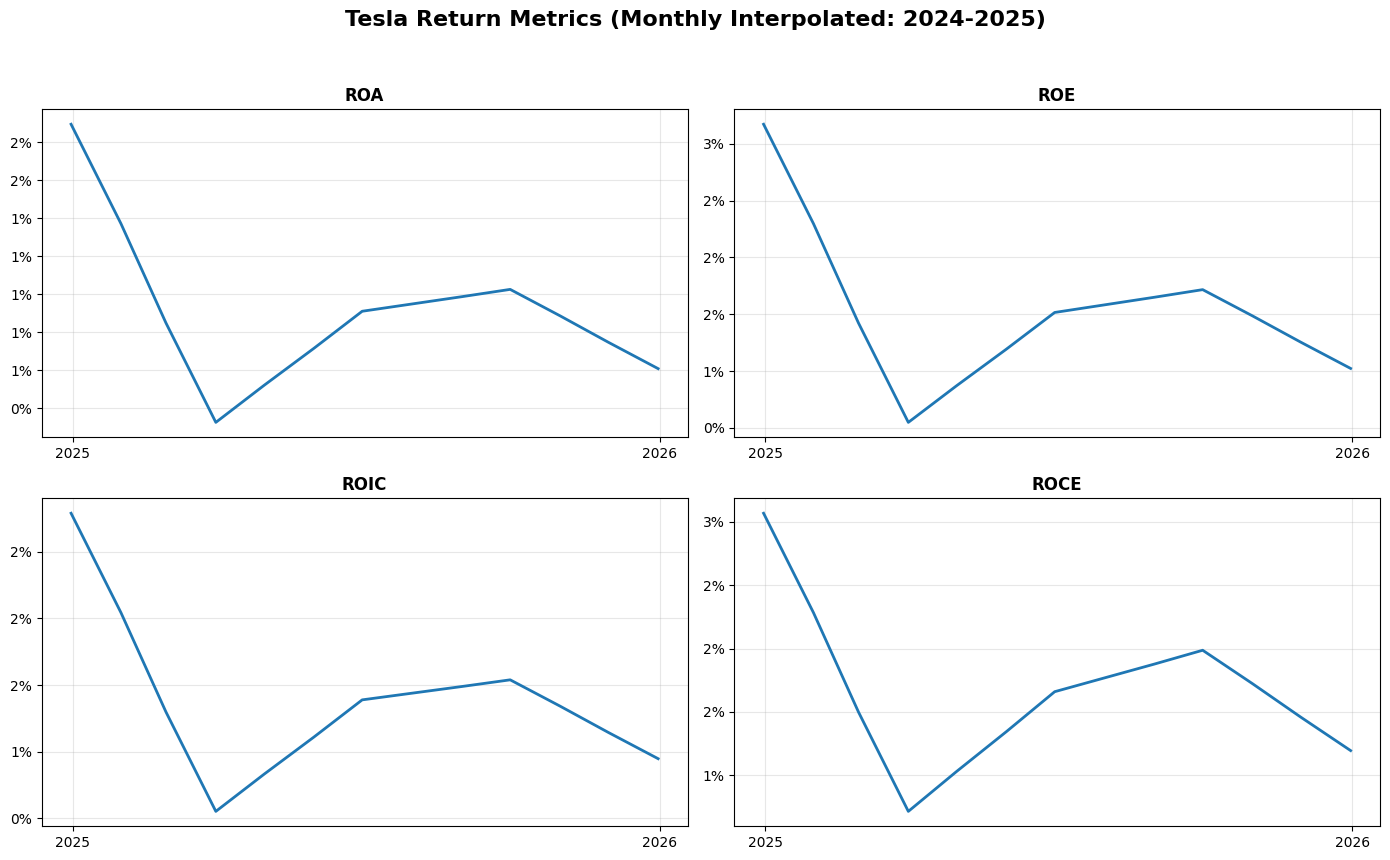

In [11]:
# Step 12: Trend Visualization
plot_trend_return_metrics()
